In [23]:
import os
import random
import math

%matplotlib inline

import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/vr1059/self-driving-data/data'
annotation_csv = '/scratch/vr1059/self-driving-data/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 128)
val_labeled_scene_index = np.arange(128, 132)
test_labeled_scene_index = np.arange(132, 134)

In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [3]:
class_label = 1
class_dict = dict()
reverse_class_dict = []
reverse_class_dict.append((-100, -100))
for i in range(400, 800, 50):
    for j in range(100, 600, 50):
        class_dict[(i, j)] = class_label
        class_label += 1
        reverse_class_dict.append((i, j))
        
class_dict[(-100, -100)] = 0

In [4]:
def round_up(x):
    return int(math.ceil(x / 50.0)) * 50

def round_down(x):
    return round_up(x) - 50

In [5]:
def front_collate_fn(batch):
    front_imgs = []
    front_right_imgs = []
    front_left_imgs = []
    target = []
    road_imgs = []
    bbs = []
    for x in batch:
        # input
        front_left_imgs.append(torch.tensor(x[0][0]))
        front_imgs.append(torch.tensor(x[0][1]))
        front_right_imgs.append(torch.tensor(x[0][2]))
        road_imgs.append(torch.tensor(x[2]))
        
        # target
        bb_tens = x[1]['bounding_box']
        bbs.append(bb_tens)
        x_min = 800
        bb_cand = (-100, -100)
        
        for i, corners in enumerate(bb_tens):
            # Get bird's eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            if xs[2] - xs[0] > 5:
                top_center_x, top_center_y = 0.5*(xs[2] + xs[3]), 0.5*(ys[2] + ys[3])
            else:
                top_center_x, top_center_y = 0.5*(xs[0] + xs[1]), 0.5*(ys[0] + ys[1])
                
            # We do (800 - top_center_y) because matplotlib y-axis starts from the top. 
            v1 = np.array([top_center_x - 400, 800 - top_center_y - 400])
            v2 = np.array([2, 0])
            
            if abs(angle_between(v1, v2)) <= 35 and x[1]['category'][i] not in [1, 3, 6, 8]:
                if top_center_x < x_min:
                    x_min = top_center_x
                    bb_cand = (top_center_x.item(), top_center_y.item())
         
        if int(bb_cand[0]) == -100:
            target.append((0, bb_cand[0], bb_cand[1]))
        else:
            key = (round_down(bb_cand[0]), round_down(bb_cand[1]))
            if key not in class_dict:
                print(bb_cand)
            label = class_dict[key]
            target.append((label, bb_cand[0], bb_cand[1]))
                
    boom = torch.stack(front_imgs), torch.tensor(target), torch.stack(road_imgs), bbs, torch.stack(front_right_imgs), torch.stack(front_left_imgs)
    return boom

In [6]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
val_transform = transforms.ToTensor()
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.5, contrast = 0.3, saturation = 0.2, hue = (-0.3, 0.3)),
        transforms.RandomAffine(10),
    ]),
    transforms.ToTensor(),
])
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=48, shuffle=True, collate_fn=front_collate_fn)
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=48, shuffle=False, collate_fn=front_collate_fn)


In [7]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet18()
        self.encoder.fc = nn.Identity()
        
        self.classification = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(512, 81)),
        ]))
        
        self.regression = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(512, 256)),
            ('bn1', nn.BatchNorm1d(256)),
            ('relu', nn.ReLU()),
            ('linear2', nn.Linear(256, 2)),
        ]))
        
        self.regression.linear2.bias = nn.Parameter(torch.tensor(4.))
        
    def forward(self, x):
        x = self.encoder(x)
        return self.regression(x)
    
model = SimpleModel()

In [9]:
device = torch.device('cpu')
model.load_state_dict(torch.load('best_val_loss_simple_class_then_reg.pt', map_location=device))

<All keys matched successfully>

### Seeing regression results

In [10]:
sample, target, road_img, bbs, front_right, front_left = iter(val_loader).next()
sample = sample.to(device)
model_preds = model(sample)

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ip

In [11]:
target

tensor([[ 25.0000, 535.5295, 328.2917],
        [ 25.0000, 528.4315, 328.1062],
        [ 25.0000, 521.9338, 328.2103],
        [ 25.0000, 516.7070, 329.0875],
        [ 25.0000, 512.3771, 329.7471],
        [ 25.0000, 509.3928, 329.7629],
        [ 25.0000, 507.2616, 329.4029],
        [  6.0000, 449.8444, 366.2456],
        [ 16.0000, 452.0586, 366.4710],
        [ 16.0000, 454.1075, 366.8654],
        [ 16.0000, 455.8737, 367.0081],
        [ 16.0000, 454.9081, 366.9337],
        [ 16.0000, 454.2909, 366.8747],
        [ 16.0000, 454.4548, 366.7947],
        [ 16.0000, 455.0555, 367.0411],
        [ 16.0000, 455.7191, 367.1723],
        [ 16.0000, 455.8591, 367.1459],
        [ 16.0000, 455.6279, 367.0294],
        [ 16.0000, 455.3472, 366.9377],
        [ 16.0000, 455.3026, 366.8576],
        [ 16.0000, 455.5162, 366.8371],
        [ 16.0000, 455.6782, 366.7972],
        [ 16.0000, 455.7176, 366.9544],
        [ 16.0000, 455.5614, 367.1263],
        [ 16.0000, 455.3880, 367.0995],


In [ ]:
idx = -1

In [ ]:
idx += 1

In [ ]:
plt.imshow(sample[idx].cpu().detach().numpy().transpose(1, 2, 0))

In [ ]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
ax.plot(target[idx][0], target[idx][1], 'x', color="blue")
ax.plot(model_preds[idx][0].cpu().detach().numpy()*100, model_preds[idx][1].cpu().detach().numpy()*100, 'x', color="green")


In [422]:
import pdb

In [423]:
model.eval()
correct = 0
total = 0 
val_losses = []
criterion = nn.CrossEntropyLoss()
for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(val_loader):

    model.eval()

    sample = sample.to(device)
    target = target.to(device)

    with torch.no_grad():
        target = target[:, 0]
        y_hat = model(sample)
        preds = torch.argmax(y_hat, dim=1)
        for i, x in enumerate(preds):
            if int(x) == int(target[i]):
                correct += 1
        total += y_hat.shape[0]
        loss = criterion(y_hat, target.long())

        val_losses.append(loss.item())

#         if i % 5 == 0:
#             print('Val Epoch: {} [{}/{} ({:.0f}%)]\tAverage Loss So Far: {:.6f}'.format(
#                 epoch, i * len(sample), len(val_loader.dataset),
#                 5. * i / len(val_loader), np.mean(val_losses)))

print("Average Val Loss: ", np.mean(val_losses))
print("\n Val Accuracy: ", 100.*correct/total)

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ip

Average Val Loss:  2.2703144279393284

 Val Accuracy:  45.833333333333336


### Evaluating Classification Model

In [7]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet18()
        self.encoder.fc = nn.Identity()
        
        self.classification = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(512, 81)),
        ]))
        
    def forward(self, x):
        x = self.encoder(x)
        return self.classification(x)
    
model = SimpleModel()

In [8]:
device = torch.device('cpu')
model.load_state_dict(torch.load('best_val_loss_simple.pt', map_location=device))

<All keys matched successfully>

In [9]:
labeled_testset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=test_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

test_loader = torch.utils.data.DataLoader(labeled_testset, batch_size=32, shuffle=True, collate_fn=front_collate_fn)

In [10]:
sample, target, road_img, bbs, front_right, front_left = iter(test_loader).next()
model_preds = model(sample)

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ip

In [11]:
model_preds

tensor([[-2.0535, -4.1635, -3.1953,  ..., -2.7731, -2.2891, -2.6706],
        [-0.7827, -4.5242, -3.5964,  ..., -2.7569, -2.4362, -2.9139],
        [-1.1139, -4.2510, -3.5958,  ..., -2.5963, -2.0018, -2.2788],
        ...,
        [ 1.8704, -3.7738, -3.0502,  ..., -2.0444, -1.0785, -0.9077],
        [ 2.0815, -3.9603, -3.2142,  ..., -1.9822, -1.3191, -1.1869],
        [ 1.2048, -4.1052, -3.2937,  ..., -2.2925, -2.1398, -2.4462]],
       grad_fn=<AddmmBackward>)

In [12]:
idx = -1

In [55]:
idx += 1

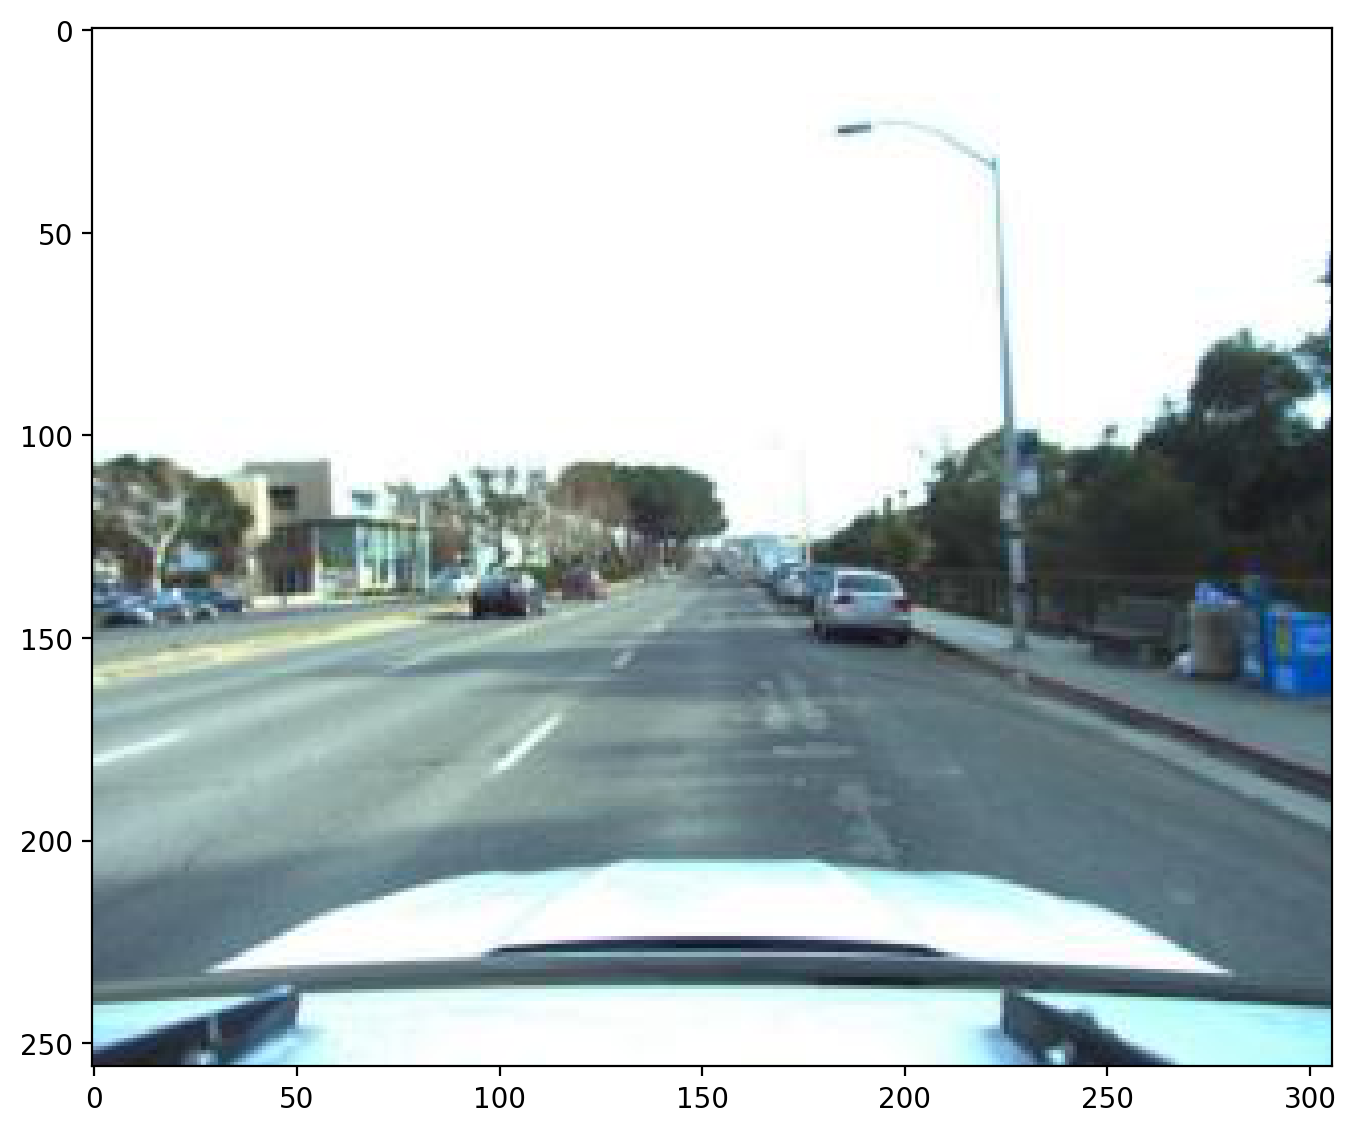

In [56]:
plt.imshow(sample[idx].numpy().transpose(1, 2, 0))

In [57]:
predicted = torch.argmax(model_preds[idx]).item()
print(predicted)
print(int(target[idx][0].item()))

46
47


In [58]:
model_preds[idx]

tensor([ 0.9531, -3.8640, -3.0031, -3.7673, -2.9379, -4.0075, -0.3934, -0.7256,
        -3.5148, -3.0007, -4.0223, -3.9107, -3.4753, -3.4027, -3.2693, -0.6760,
        -0.4363,  0.1305, -1.6804, -3.2565, -3.5515, -3.3017, -3.5868, -2.9699,
        -3.6069, -0.3752, -1.0979, -0.6096,  0.5124, -1.6807, -2.7805, -3.0272,
        -3.9800, -2.3315,  0.3714, -0.2792,  1.2110,  0.0488,  0.7142,  0.7311,
        -3.5484, -3.4062, -2.8206, -0.9162,  0.9926,  0.7592,  2.0716,  0.8391,
        -0.2029,  0.7467, -1.4039, -3.9478, -3.1504,  0.0307,  0.3786,  0.1012,
         1.9632,  0.0810, -1.1764, -1.3849, -0.0577, -2.7333, -1.3364, -1.0093,
        -1.1904, -0.4161,  1.3924, -1.2388, -3.3373, -0.4363, -0.3200, -2.9857,
        -1.5506, -2.4731, -3.9090, -0.6315,  1.0789, -0.8616, -2.1383, -1.3418,
        -1.2295], grad_fn=<SelectBackward>)

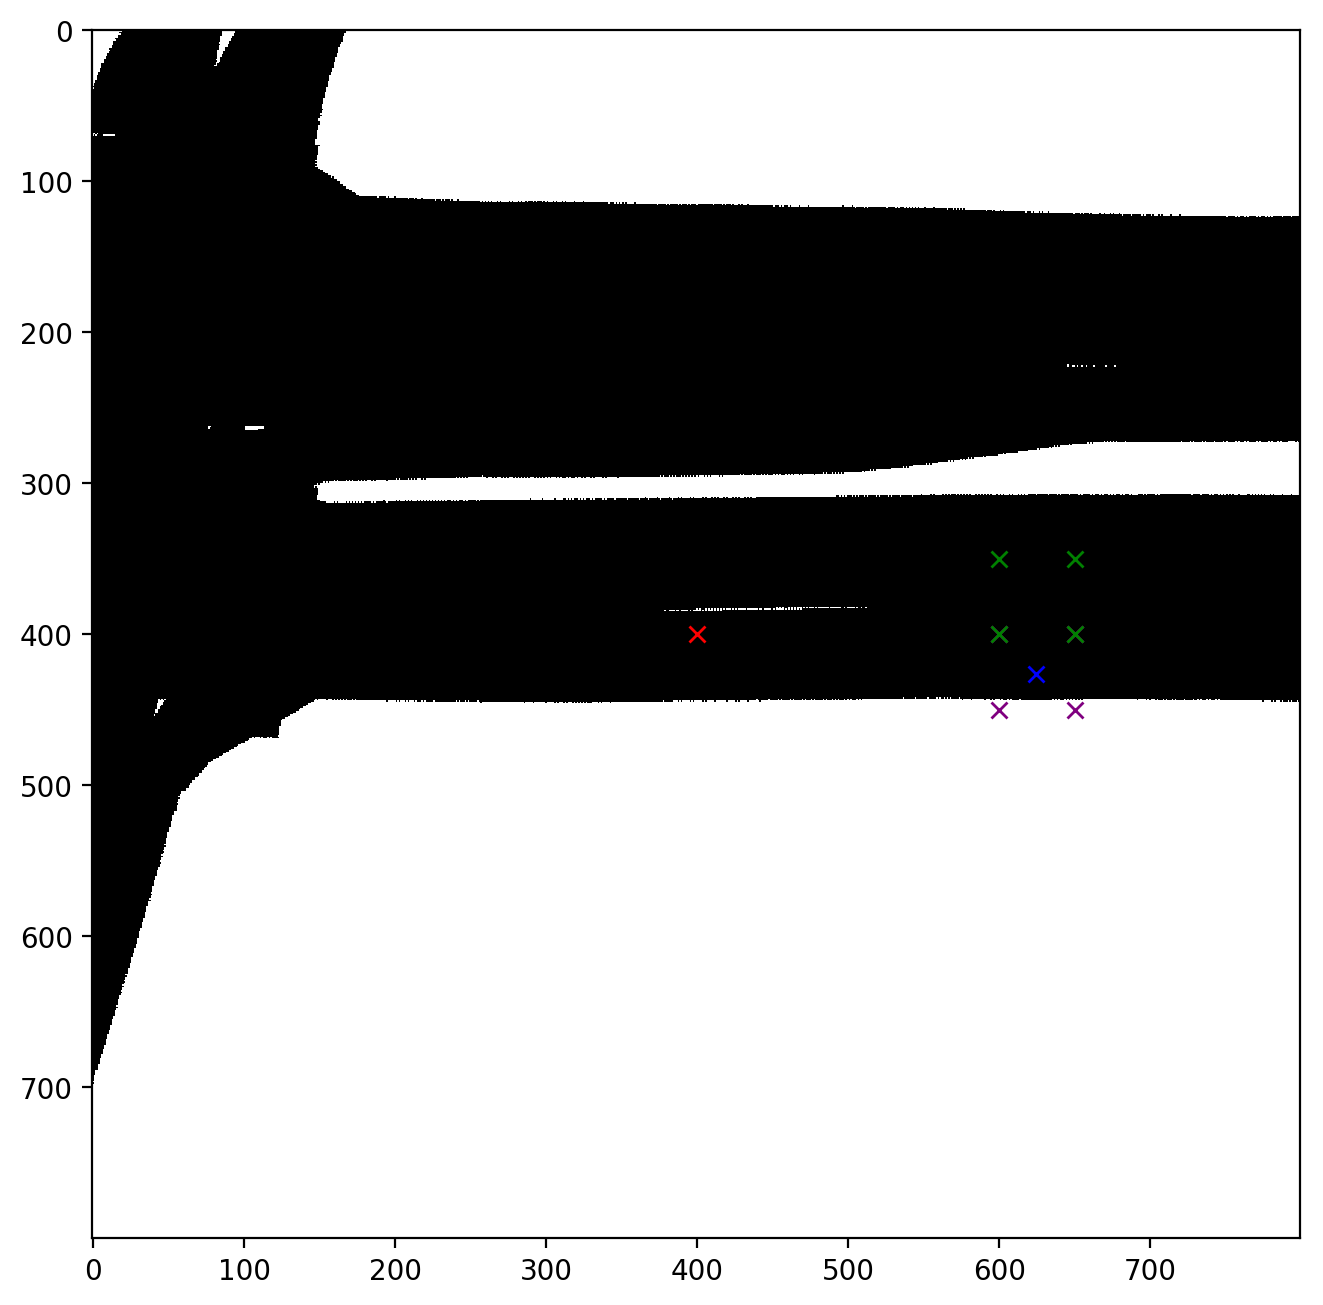

In [59]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
ax.plot(target[idx][1], target[idx][2], 'x', color="blue")
class_box = reverse_class_dict[int(target[idx][0].item())]
box_xs = [class_box[0], class_box[0], class_box[0]+50, class_box[0]+50]
box_ys = [class_box[1], class_box[1]+50, class_box[1], class_box[1]+50]
ax.plot(box_xs, box_ys, 'x', color="purple")
predicted_box = reverse_class_dict[int(predicted)]
box_xs = [predicted_box[0], predicted_box[0], predicted_box[0]+50, predicted_box[0]+50]
box_ys = [predicted_box[1], predicted_box[1]+50, predicted_box[1], predicted_box[1]+50]
ax.plot(box_xs, box_ys, 'x', color="green")

In [34]:
!nvidia-smi

Tue Apr 21 17:19:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1E:00.0 Off |                    0 |
| N/A   49C    P0    65W / 300W |   9246MiB / 16130MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  